In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import HTML

In [3]:
# Load the csv file
df = pd.read_csv('CAN1995ttl.csv')  # Update the path to your file
# Extract the matrix Z from the second row and second column to row 45 and column 45
Z = df.iloc[0:44, 1:45].to_numpy()  # Convert the selected dataframe portion to a numpy array
# Convert the DataFrame to float
Z = Z.astype(float)
# Extract the row vector 'output' from the last row and specified columns
output = df.iloc[49, 1:45].to_numpy()  # Assuming the last row is row 51 (index 50 in Python)
# Convert the DataFrame to float
output = output.astype(float)
# Ensure the output vector does not contain zeros to avoid division by zero issues
if np.any(output == 0):
    print("Warning: Division by zero encountered due to zero elements in 'output' vector.")
else:
    # Create matrix A by dividing each column of Z by the corresponding element in output
    A = Z / output
# Create an identity matrix I of size 44x44
I = np.eye(44)

# Compute I - A
I_minus_A = I - A

# Calculate the inverse of (I - A) to get matrix L
try:
    L = np.linalg.inv(I_minus_A)
except np.linalg.LinAlgError:
    print("The matrix (I - A) is singular and cannot be inverted.")
# Matrices A, L, and vector output are already defined
L_T = L.T  # Transpose of the Leontief matrix L
L_diag = np.diag(L)  # Diagonal elements of L

# Reshape output for broadcasting in matrix operations
x_k = output.reshape(1, -1)  # Row vector
x_j = output.reshape(-1, 1)  # Column vector

# Initialize matrix C with the same dimensions as A
C = np.zeros_like(A)

# Calculate each element of matrix C
for j in range(A.shape[0]):
    for k in range(A.shape[1]):
        denominator = A[j, k] * (L_T[k, j] / 100 + L_diag[j] * x_k[0, k] / x_j[j, 0])
        if denominator != 0:
            C[j, k] = 1 / denominator
        else:
            C[j, k] = 0  # Handle division by zero if it occurs
# Initialize the matrix Ci with the same shape as C
Ci = np.zeros_like(C, dtype=int)

# Apply the conditions to each element in matrix C to determine the values in Ci
Ci[(C > 0) & (C < 25)] = 1

# Set the diagonal elements to 1 to ensure the matrix is reflexive
np.fill_diagonal(Ci, 1)
# Ci is already defined as a binary matrix from previous steps

# Initialize the current power matrix as Ci
current_power = Ci

# Dictionary to store each power of Ci and their column sums
powers = {"C1": Ci}
column_sums = {"C1": np.sum(Ci, axis=0)}  # Include the sum of the original Ci

# Variable to keep track of the number of multiplications
n = 1

# Loop to find the idempotent power of Ci and calculate column sums
while True:
    # Multiply the current matrix power by Ci
    next_power = np.matmul(current_power, Ci)
    
    # Convert result to a binary matrix: 1 if > 0, otherwise 0
    next_power = (next_power > 0).astype(int)
    
    n += 1  # Update the power index
    powers[f"C{n}"] = next_power  # Store the result
    
    # Calculate and store column sums for each matrix
    column_sums[f"C{n}"] = np.sum(next_power, axis=0)
    
    # Check if the matrix has become idempotent
    if np.array_equal(next_power, current_power):
        print(f"Matrix became idempotent at power C{n}")
        idempotent_power = n  # Capture the idempotent power level for reference outside the loop
        break

    # Update the current power for the next iteration
    current_power = next_power

# Create a new matrix to store the column sums as columns, excluding the last repeated column
result_matrix = np.column_stack([column_sums[key] for key in sorted(column_sums)[:-1]])  # Exclude the last repetitive column

Matrix became idempotent at power C8


In [5]:
# Colors for each step in hex or color names
color_cycle = ['black', 'red', 'blue', 'green', 'magenta',  'orange', 'cyan']  # Extend as needed
# Creating the summary DataFrame
summary_table = pd.DataFrame(index=range(1, len(powers['C1']) + 1))

# Convert binary matrix to sets of related rows
related_rows_per_step = {key: [set(np.where(col == 1)[0] + 1) for col in matrix.T] for key, matrix in powers.items()}

# Fill the summary table with relationships for each power
previous_step = None
for step_index, (key, related_rows) in enumerate(related_rows_per_step.items()):
    formatted_columns = []
    for i, rows in enumerate(related_rows):
        if previous_step:
            new_rows = rows - previous_step[i]
            old_rows = rows.intersection(previous_step[i])
            colored_new_rows = [f"<span style='color:{color_cycle[step_index % len(color_cycle)]};'>{row}</span>" for row in new_rows]
            colored_old_rows = [f"<span style='color:black;'>{row}</span>" for row in old_rows]
            formatted_columns.append(', '.join(colored_old_rows + colored_new_rows))
        else:
            formatted_columns.append(', '.join(f"<span style='color:black;'>{row}</span>" for row in rows))
    summary_table[key] = formatted_columns
    previous_step = related_rows

# Exclude the last column from the DataFrame before converting to HTML
summary_table_display = summary_table.iloc[:, :-1]

# Convert the adjusted DataFrame to HTML to enable the colored text
html = summary_table_display.to_html(escape=False)

# Display the DataFrame with HTML styling
HTML(html)

,C1,C2,C3,C4,C5,C6,C7
1,"1, 6, 10, 11, 22, 27, 28","1, 6, 10, 11, 22, 27, 28, 2, 3, 7, 9, 13, 14, 15, 16, 26, 30","1, 2, 3, 6, 7, 9, 10, 11, 13, 14, 15, 16, 22, 26, 27, 28, 30, 34, 35, 4, 5, 36, 37, 8, 38, 39, 19, 23, 24, 31","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 19, 22, 23, 24, 26, 27, 28, 30, 31, 34, 35, 36, 37, 38, 39, 17, 25, 33","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 18, 21","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39"
2,2,2,2,2,2,2,2
3,"19, 35, 3, 5","3, 35, 19, 5, 16, 15","35, 3, 5, 15, 16, 19, 4, 14, 23, 27, 30","35, 3, 4, 5, 14, 15, 16, 19, 23, 27, 30, 10","35, 3, 4, 5, 10, 14, 15, 16, 19, 23, 27, 30","35, 3, 4, 5, 10, 14, 15, 16, 19, 23, 27, 30","35, 3, 4, 5, 10, 14, 15, 16, 19, 23, 27, 30"
4,"19, 4, 5","19, 4, 5, 16, 15","4, 5, 15, 16, 19, 27, 30, 14, 23","4, 5, 14, 15, 16, 19, 23, 27, 30, 10","4, 5, 10, 14, 15, 16, 19, 23, 27, 30, 3","3, 4, 5, 10, 14, 15, 16, 19, 23, 27, 30, 35","35, 3, 4, 5, 10, 14, 15, 16, 19, 23, 27, 30"
5,5,5,5,5,5,5,5
6,"1, 2, 6, 9, 13, 14, 16, 26, 30","1, 2, 6, 9, 13, 14, 16, 26, 30, 34, 35, 36, 37, 38, 39, 8, 10, 11, 15, 22, 23, 24, 27, 28, 31","1, 2, 6, 8, 9, 10, 11, 13, 14, 15, 16, 22, 23, 24, 26, 27, 28, 30, 31, 34, 35, 36, 37, 38, 39, 33, 3, 4, 7, 17, 25","1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 21, 18, 19, 5","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39"
7,7,7,7,7,7,7,7
8,"8, 1","8, 1, 6, 10, 11, 22, 27, 28","1, 6, 8, 10, 11, 22, 27, 28, 2, 3, 7, 9, 13, 14, 15, 16, 26, 30","1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 22, 26, 27, 28, 30, 34, 35, 4, 5, 36, 37, 38, 39, 19, 23, 24, 31","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 19, 22, 23, 24, 26, 27, 28, 30, 31, 34, 35, 36, 37, 38, 39, 17, 25, 33","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 18, 21","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39"
9,"1, 8, 9, 11, 22, 23, 28, 30","1, 8, 9, 11, 22, 23, 28, 30, 6, 7, 10, 13, 15, 27","1, 6, 7, 8, 9, 10, 11, 13, 15, 22, 23, 27, 28, 30, 2, 3, 4, 14, 16, 26","1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 22, 23, 26, 27, 28, 30, 34, 35, 36, 5, 37, 38, 39, 19, 24, 31","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 19, 22, 23, 24, 26, 27, 28, 30, 31, 34, 35, 36, 37, 38, 39, 17, 25, 33","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 18, 21","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39"
10,"10, 3","10, 3, 19, 35, 5","3, 35, 5, 10, 19, 16, 15","35, 3, 5, 10, 15, 16, 19, 4, 14, 23, 27, 30","35, 3, 4, 5, 10, 14, 15, 16, 19, 23, 27, 30","35, 3, 4, 5, 10, 14, 15, 16, 19, 23, 27, 30","35, 3, 4, 5, 10, 14, 15, 16, 19, 23, 27, 30"


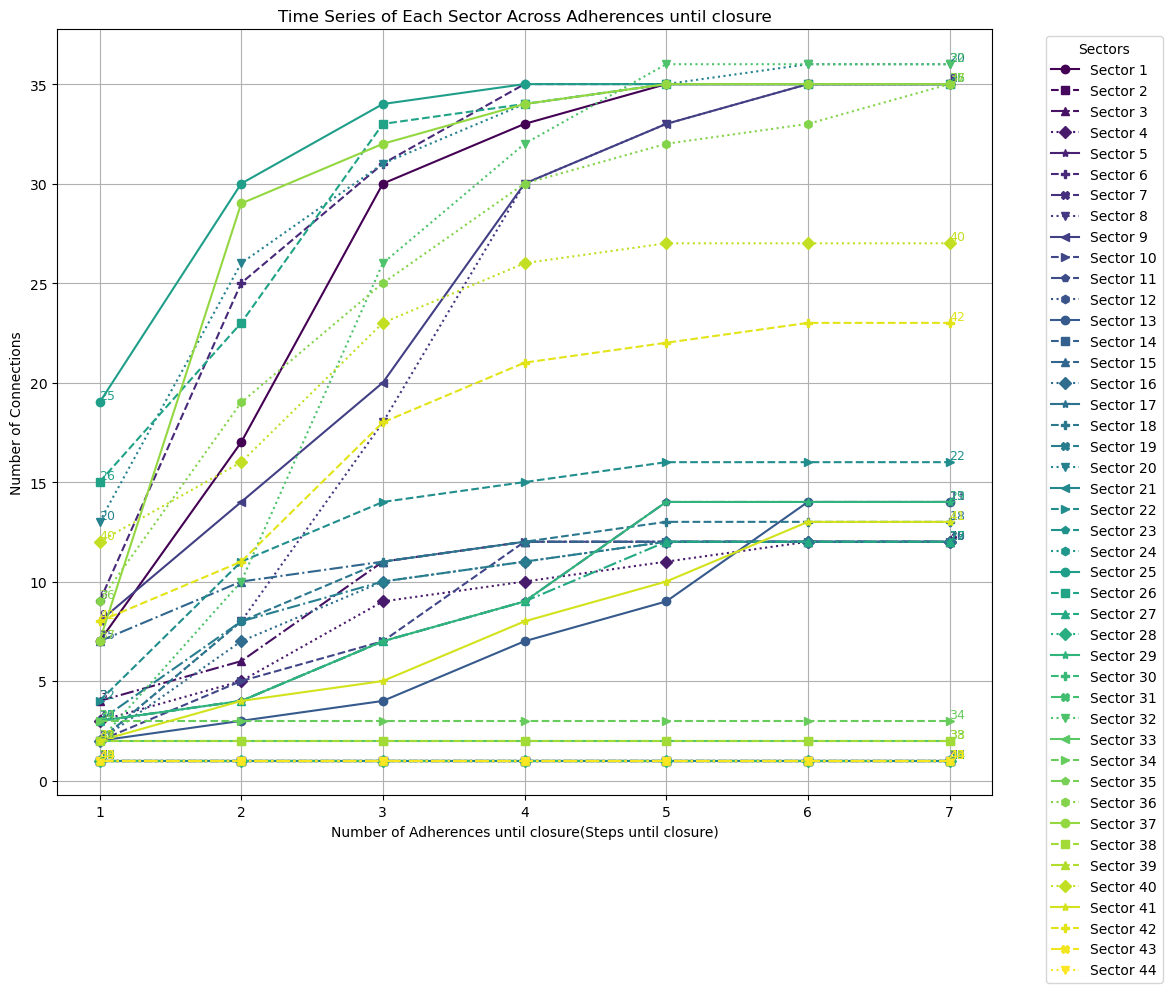

In [7]:
# result_matrix is already defined as shown in the previous steps

# Define the number of sectors (rows) and the number of powers (columns)
num_sectors = result_matrix.shape[0]
num_powers = result_matrix.shape[1]

# Create a color map to assign different colors to each line
colors = cm.viridis(np.linspace(0, 1, num_sectors))

# Define a list of markers and line styles to differentiate the sectors more clearly
markers = ['o', 's', '^', 'D', '*', 'P', 'X', 'v', '<', '>', 'p', 'h']
line_styles = ['-', '--', '-.', ':']

# Start plotting
plt.figure(figsize=(14, 10))
for i in range(num_sectors):
    # Choose marker and line style cyclically from the list
    marker = markers[i % len(markers)]
    line_style = line_styles[i % len(line_styles)]

    # Extract the row data for the current sector
    sector_data = result_matrix[i, :]
    
    # Plot the data with specific marker and line style
    plt.plot(range(1, num_powers + 1), sector_data, label=f'Sector {i + 1}', color=colors[i], linestyle=line_style, marker=marker)
    
    # Annotate the beginning of the line
    plt.text(1, sector_data[0], f'{i + 1}', color=colors[i], fontsize=9, verticalalignment='bottom')
    
    # Annotate the end of the line
    plt.text(num_powers, sector_data[-1], f'{i + 1}', color=colors[i], fontsize=9, verticalalignment='bottom')

# Adding legend outside the plot
plt.legend(title='Sectors', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding titles and labels
plt.title('Time Series of Each Sector Across Adherences until closure')
plt.xlabel('Number of Adherences until closure(Steps until closure)')
plt.ylabel('Number of Connections')

# Show grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to fit the legend outside the plot
plt.show()

In [31]:
# Load the csv file
df = pd.read_csv('CAN2019ttl.csv')  # Update the path to your file
# Extract the matrix Z from the second row and second column to row 45 and column 45
Z = df.iloc[0:44, 1:45].to_numpy()  # Convert the selected dataframe portion to a numpy array
# Convert the DataFrame to float
Z = Z.astype(float)
# Extract the row vector 'output' from the last row and specified columns
output = df.iloc[49, 1:45].to_numpy()  # Assuming the last row is row 51 (index 50 in Python)
# Convert the DataFrame to float
output = output.astype(float)
# Ensure the output vector does not contain zeros to avoid division by zero issues
if np.any(output == 0):
    print("Warning: Division by zero encountered due to zero elements in 'output' vector.")
else:
    # Create matrix A by dividing each column of Z by the corresponding element in output
    A = Z / output
# Create an identity matrix I of size 44x44
I = np.eye(44)

# Compute I - A
I_minus_A = I - A

# Calculate the inverse of (I - A) to get matrix L
try:
    L = np.linalg.inv(I_minus_A)
except np.linalg.LinAlgError:
    print("The matrix (I - A) is singular and cannot be inverted.")
# Matrices A, L, and vector output are already defined
L_T = L.T  # Transpose of the Leontief matrix L
L_diag = np.diag(L)  # Diagonal elements of L

# Reshape output for broadcasting in matrix operations
x_k = output.reshape(1, -1)  # Row vector
x_j = output.reshape(-1, 1)  # Column vector

# Initialize matrix C with the same dimensions as A
C = np.zeros_like(A)

# Calculate each element of matrix C
for j in range(A.shape[0]):
    for k in range(A.shape[1]):
        denominator = A[j, k] * (L_T[k, j] / 100 + L_diag[j] * x_k[0, k] / x_j[j, 0])
        if denominator != 0:
            C[j, k] = 1 / denominator
        else:
            C[j, k] = 0  # Handle division by zero if it occurs
# Initialize the matrix Ci with the same shape as C
Ci = np.zeros_like(C, dtype=int)

# Apply the conditions to each element in matrix C to determine the values in Ci
Ci[(C > 0) & (C < 25)] = 1

# Set the diagonal elements to 1 to ensure the matrix is reflexive
np.fill_diagonal(Ci, 1)
# Ci is already defined as a binary matrix from previous steps

# Initialize the current power matrix as Ci
current_power = Ci

# Dictionary to store each power of Ci and their column sums
powers = {"C1": Ci}
column_sums = {"C1": np.sum(Ci, axis=0)}  # Include the sum of the original Ci

# Variable to keep track of the number of multiplications
n = 1

# Loop to find the idempotent power of Ci and calculate column sums
while True:
    # Multiply the current matrix power by Ci
    next_power = np.matmul(current_power, Ci)
    
    # Convert result to a binary matrix: 1 if > 0, otherwise 0
    next_power = (next_power > 0).astype(int)
    
    n += 1  # Update the power index
    powers[f"C{n}"] = next_power  # Store the result
    
    # Calculate and store column sums for each matrix
    column_sums[f"C{n}"] = np.sum(next_power, axis=0)
    
    # Check if the matrix has become idempotent
    if np.array_equal(next_power, current_power):
        print(f"Matrix became idempotent at power C{n}")
        idempotent_power = n  # Capture the idempotent power level for reference outside the loop
        break

    # Update the current power for the next iteration
    current_power = next_power

# Create a new matrix to store the column sums as columns, excluding the last repeated column
result_matrix = np.column_stack([column_sums[key] for key in sorted(column_sums)[:-1]])  # Exclude the last repetitive column

Matrix became idempotent at power C8


In [33]:
# Colors for each step in hex or color names
color_cycle = ['black', 'red', 'blue', 'green', 'magenta',  'orange', 'cyan', 'olive', 'pink', 'red']  # Extend as needed
# Creating the summary DataFrame
summary_table = pd.DataFrame(index=range(1, len(powers['C1']) + 1))

# Convert binary matrix to sets of related rows
related_rows_per_step = {key: [set(np.where(col == 1)[0] + 1) for col in matrix.T] for key, matrix in powers.items()}

# Fill the summary table with relationships for each power
previous_step = None
for step_index, (key, related_rows) in enumerate(related_rows_per_step.items()):
    formatted_columns = []
    for i, rows in enumerate(related_rows):
        if previous_step:
            new_rows = rows - previous_step[i]
            old_rows = rows.intersection(previous_step[i])
            colored_new_rows = [f"<span style='color:{color_cycle[step_index % len(color_cycle)]};'>{row}</span>" for row in new_rows]
            colored_old_rows = [f"<span style='color:black;'>{row}</span>" for row in old_rows]
            formatted_columns.append(', '.join(colored_old_rows + colored_new_rows))
        else:
            formatted_columns.append(', '.join(f"<span style='color:black;'>{row}</span>" for row in rows))
    summary_table[key] = formatted_columns
    previous_step = related_rows

# Exclude the last column from the DataFrame before converting to HTML
summary_table_display = summary_table.iloc[:, :-1]

# Convert the adjusted DataFrame to HTML to enable the colored text
html = summary_table_display.to_html(escape=False)

# Display the DataFrame with HTML styling
HTML(html)

,C1,C2,C3,C4,C5,C6,C7
1,"1, 6, 10, 11, 13, 27, 28","1, 6, 10, 11, 13, 27, 28, 2, 3, 7, 9, 26, 30","1, 2, 3, 6, 7, 9, 10, 11, 13, 26, 27, 28, 30, 33, 35, 36, 5, 38, 39, 8, 19, 21, 24, 31","1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 19, 21, 24, 26, 27, 28, 30, 31, 33, 35, 36, 38, 39, 34, 15, 16, 17, 18, 29","1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 4","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39"
2,2,2,2,2,2,2,2
3,"3, 5, 38, 19, 24","3, 5, 38, 19, 24, 35, 39, 15, 16, 17, 28, 29","35, 3, 5, 38, 39, 15, 16, 17, 19, 24, 28, 29, 33, 4, 10, 11, 18, 21, 30, 31","3, 4, 5, 10, 11, 15, 16, 17, 18, 19, 21, 24, 28, 29, 30, 31, 33, 35, 38, 39, 27","3, 4, 5, 10, 11, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 30, 31, 33, 35, 38, 39","3, 4, 5, 10, 11, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 30, 31, 33, 35, 38, 39","3, 4, 5, 10, 11, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 30, 31, 33, 35, 38, 39"
4,"28, 4, 5","5, 28, 4","5, 28, 4","5, 28, 4","5, 28, 4","5, 28, 4","5, 28, 4"
5,5,5,5,5,5,5,5
6,"1, 2, 6, 9, 13, 26, 27, 30","1, 2, 6, 9, 13, 26, 27, 30, 33, 35, 36, 38, 7, 8, 39, 10, 11, 21, 24, 28, 31","1, 2, 6, 7, 8, 9, 10, 11, 13, 21, 24, 26, 27, 28, 30, 31, 33, 35, 36, 38, 39, 34, 3, 17, 18, 29","1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 17, 18, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 19, 5","1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 16, 15","1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 4","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39"
7,7,7,7,7,7,7,7
8,"8, 1","8, 1, 6, 10, 11, 13, 27, 28","1, 6, 8, 10, 11, 13, 27, 28, 2, 3, 7, 9, 26, 30","1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 26, 27, 28, 30, 33, 35, 36, 5, 38, 39, 19, 21, 24, 31","1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 19, 21, 24, 26, 27, 28, 30, 31, 33, 35, 36, 38, 39, 34, 15, 16, 17, 18, 29","1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 4","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39"
9,"8, 9, 28","8, 9, 28, 1","8, 1, 28, 9, 6, 10, 11, 13, 27","1, 6, 8, 9, 10, 11, 13, 27, 28, 2, 3, 7, 26, 30","1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 26, 27, 28, 30, 33, 35, 36, 5, 38, 39, 19, 21, 24, 31","1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 19, 21, 24, 26, 27, 28, 30, 31, 33, 35, 36, 38, 39, 34, 15, 16, 17, 18, 29","1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 4"
10,"27, 10, 3","3, 10, 27, 5, 38, 19, 24, 30","3, 5, 38, 10, 19, 24, 27, 30, 35, 39, 15, 16, 17, 28, 29","35, 3, 5, 38, 39, 10, 15, 16, 17, 19, 24, 27, 28, 29, 30, 33, 4, 11, 18, 21, 31","3, 4, 5, 10, 11, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 30, 31, 33, 35, 38, 39","3, 4, 5, 10, 11, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 30, 31, 33, 35, 38, 39","3, 4, 5, 10, 11, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 30, 31, 33, 35, 38, 39"


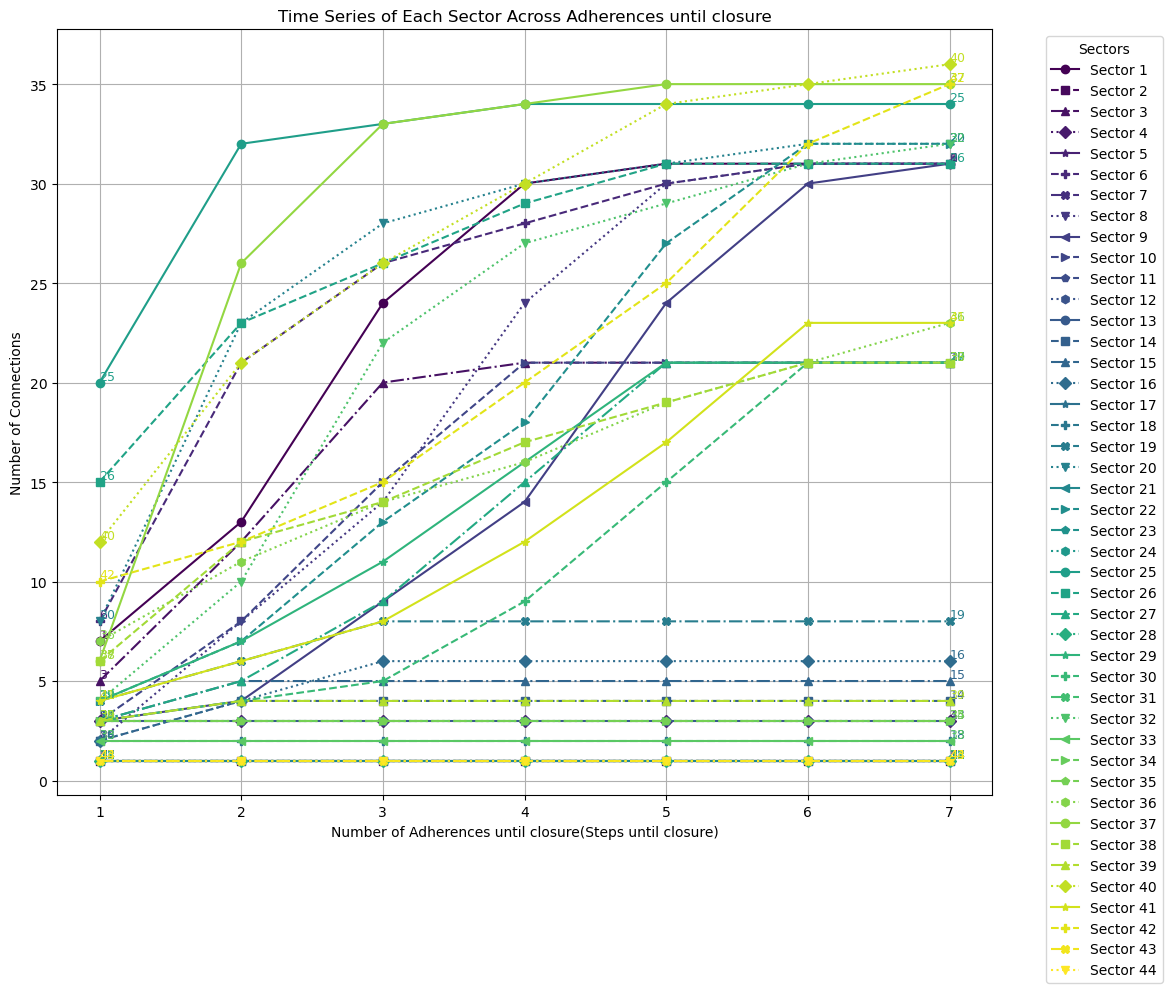

In [35]:
# result_matrix is already defined as shown in the previous steps

# Define the number of sectors (rows) and the number of powers (columns)
num_sectors = result_matrix.shape[0]
num_powers = result_matrix.shape[1]

# Create a color map to assign different colors to each line
colors = cm.viridis(np.linspace(0, 1, num_sectors))

# Define a list of markers and line styles to differentiate the sectors more clearly
markers = ['o', 's', '^', 'D', '*', 'P', 'X', 'v', '<', '>', 'p', 'h']
line_styles = ['-', '--', '-.', ':']

# Start plotting
plt.figure(figsize=(14, 10))
for i in range(num_sectors):
    # Choose marker and line style cyclically from the list
    marker = markers[i % len(markers)]
    line_style = line_styles[i % len(line_styles)]

    # Extract the row data for the current sector
    sector_data = result_matrix[i, :]
    
    # Plot the data with specific marker and line style
    plt.plot(range(1, num_powers + 1), sector_data, label=f'Sector {i + 1}', color=colors[i], linestyle=line_style, marker=marker)
    
    # Annotate the beginning of the line
    plt.text(1, sector_data[0], f'{i + 1}', color=colors[i], fontsize=9, verticalalignment='bottom')
    
    # Annotate the end of the line
    plt.text(num_powers, sector_data[-1], f'{i + 1}', color=colors[i], fontsize=9, verticalalignment='bottom')

# Adding legend outside the plot
plt.legend(title='Sectors', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding titles and labels
plt.title('Time Series of Each Sector Across Adherences until closure')
plt.xlabel('Number of Adherences until closure(Steps until closure)')
plt.ylabel('Number of Connections')

# Show grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to fit the legend outside the plot
plt.show()

In [15]:
def process_matrix(year):
    file_path = f'CAN{year}ttl.csv'
    df = pd.read_csv(file_path)

    Z = df.iloc[0:44, 1:45].astype(float).to_numpy()
    output = df.iloc[49, 1:45].astype(float).to_numpy()

    if np.any(output == 0):
        raise ValueError("Output contains zero, which will lead to division by zero.")

    A = Z / output.reshape(1, -1)
    I = np.eye(44)
    I_minus_A = I - A

    try:
        L = np.linalg.inv(I_minus_A)
    except np.linalg.LinAlgError:
        raise Exception(f"The matrix (I - A) for year {year} is singular and cannot be inverted.")
    
    L_T = L.T  # Transpose of the Leontief matrix L
    L_diag = np.diag(L)
    # Reshape output for broadcasting in matrix operations
    x_k = output.reshape(1, -1)  # Row vector
    x_j = output.reshape(-1, 1)  # Column vector
    # Initialize matrix C with the same dimensions as A
    C = np.zeros_like(A)   

    # Calculate each element of matrix C
    for j in range(A.shape[0]):
        for k in range(A.shape[1]):
            denominator = A[j, k] * (L_T[k, j] / 100 + L_diag[j] * x_k[0, k] / x_j[j, 0])
            if denominator != 0:
                C[j, k] = 1 / denominator
            else:
                C[j, k] = 0  # Handle division by zero if it occurs

    # Initialize the matrix Ci with the same shape as C
    Ci = np.zeros_like(C, dtype=int)
    
    # Apply the conditions to each element in matrix C to determine the values in Ci
    Ci[(C > 0) & (C < 25)] = 1

    
    np.fill_diagonal(Ci, 1)  # Make matrix reflexive

    # Initialize variables for idempotence calculation
    current_power = Ci
    column_sums = {"C1": np.sum(Ci, axis=0)}
    powers = {"C1": Ci}
    n = 1

    while True:
        next_power = np.matmul(current_power, Ci)
        next_power = (next_power > 0).astype(int)

        n += 1
        powers[f"C{n}"] = next_power
        column_sums[f"C{n}"] = np.sum(next_power, axis=0)

        if np.array_equal(next_power, current_power):
            break

        current_power = next_power

    result_matrix = np.column_stack([column_sums[key] for key in sorted(column_sums)[:-1]])

    return result_matrix

first_adherence = pd.DataFrame()
closure = pd.DataFrame()

for year in range(1995, 2021):
    try:
        result_matrix = process_matrix(year)
        first_adherence[year] = result_matrix[:, 0]
        closure[year] = result_matrix[:, -1]
    except Exception as e:
        print(f"Error processing year {year}: {e}")

# Output the tables to CSV files
first_adherence.to_csv('first_adherence_CAN.csv')
closure.to_csv('closure_CAN.csv')

In [17]:
def plot_data(df, title):
    plt.figure(figsize=(14, 10))
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    line_styles = ['-', '--', '-.', ':']
    num_lines = len(df.index)

    # Reset the DataFrame index to start from 1 if not already
    if df.index[0] == 0:
        df.index = range(1, num_lines + 1)

    # Calculate offsets to avoid overlapping of annotations
    y_offsets = np.linspace(0.02, -0.02, num_lines)

    for i, (index, row) in enumerate(df.iterrows()):
        marker = markers[i % len(markers)]
        line_style = line_styles[i % len(line_styles)]
        line, = plt.plot(df.columns, row, label=f'Sector {index}', marker=marker, linestyle=line_style, linewidth=2)

        # Adjust text annotations to avoid overlap
        start_offset = y_offsets[i % len(y_offsets)]
        end_offset = y_offsets[-(i % len(y_offsets)) - 1]  # Reverse direction for end offset

        # Annotate the first and last point on the plot, adjusted by the offsets
        plt.text(df.columns[0], row.iloc[0] + start_offset, str(index), color=line.get_color(), fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right')
        plt.text(df.columns[-1], row.iloc[-1] + end_offset, str(index), color=line.get_color(), fontsize=9,
                 verticalalignment='bottom', horizontalalignment='left')

    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Connections')
    plt.xticks(rotation=45)
    plt.legend(title='Sectors', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Assuming first_adherence and closure are already loaded or computed DataFrames
first_adherence = pd.read_csv('first_adherence_CAN.csv', index_col=0)  # load if not in memory
closure = pd.read_csv('closure_CAN.csv', index_col=0)  # load if not in memory




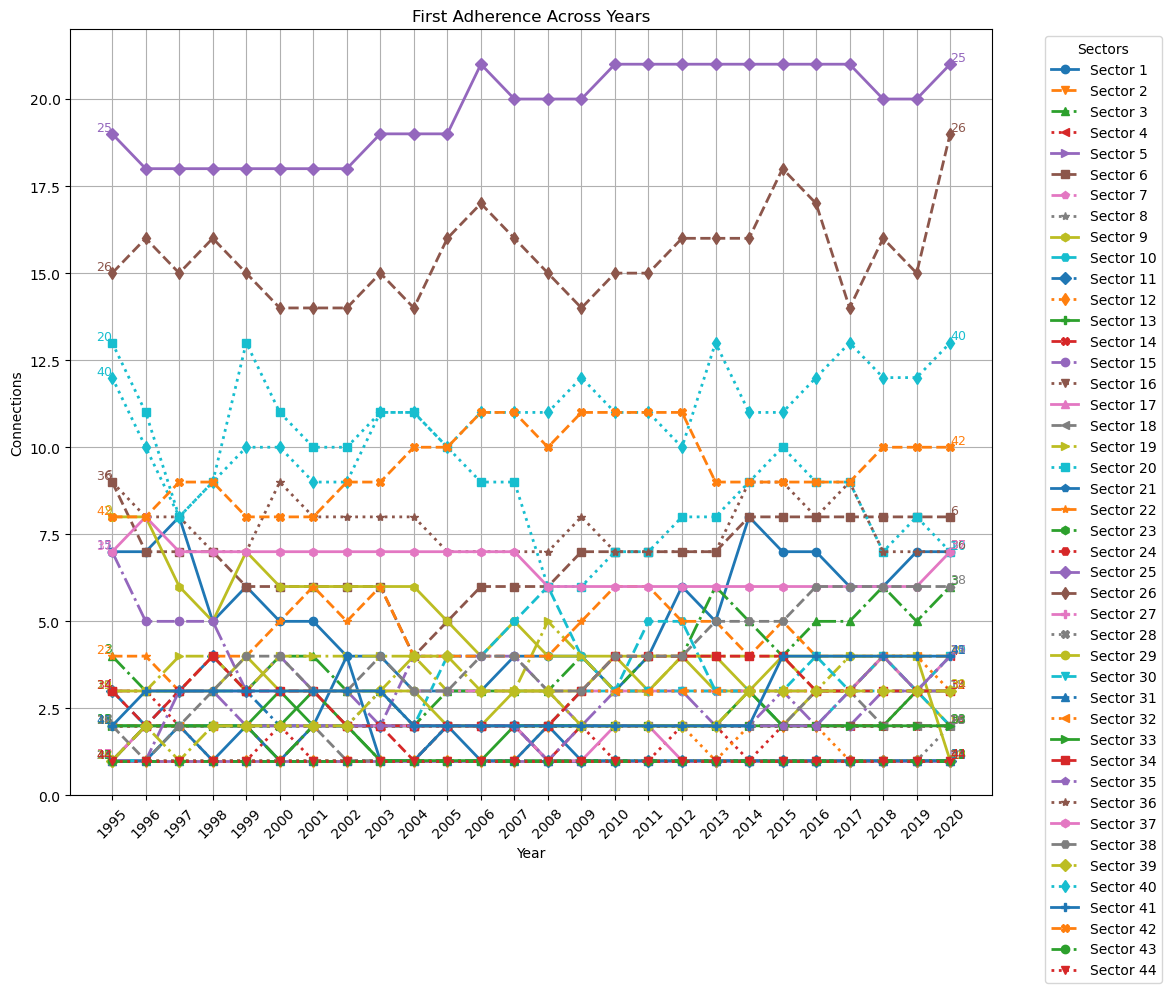

In [19]:
# Plotting first_adherence and closure
plot_data(first_adherence, 'First Adherence Across Years')


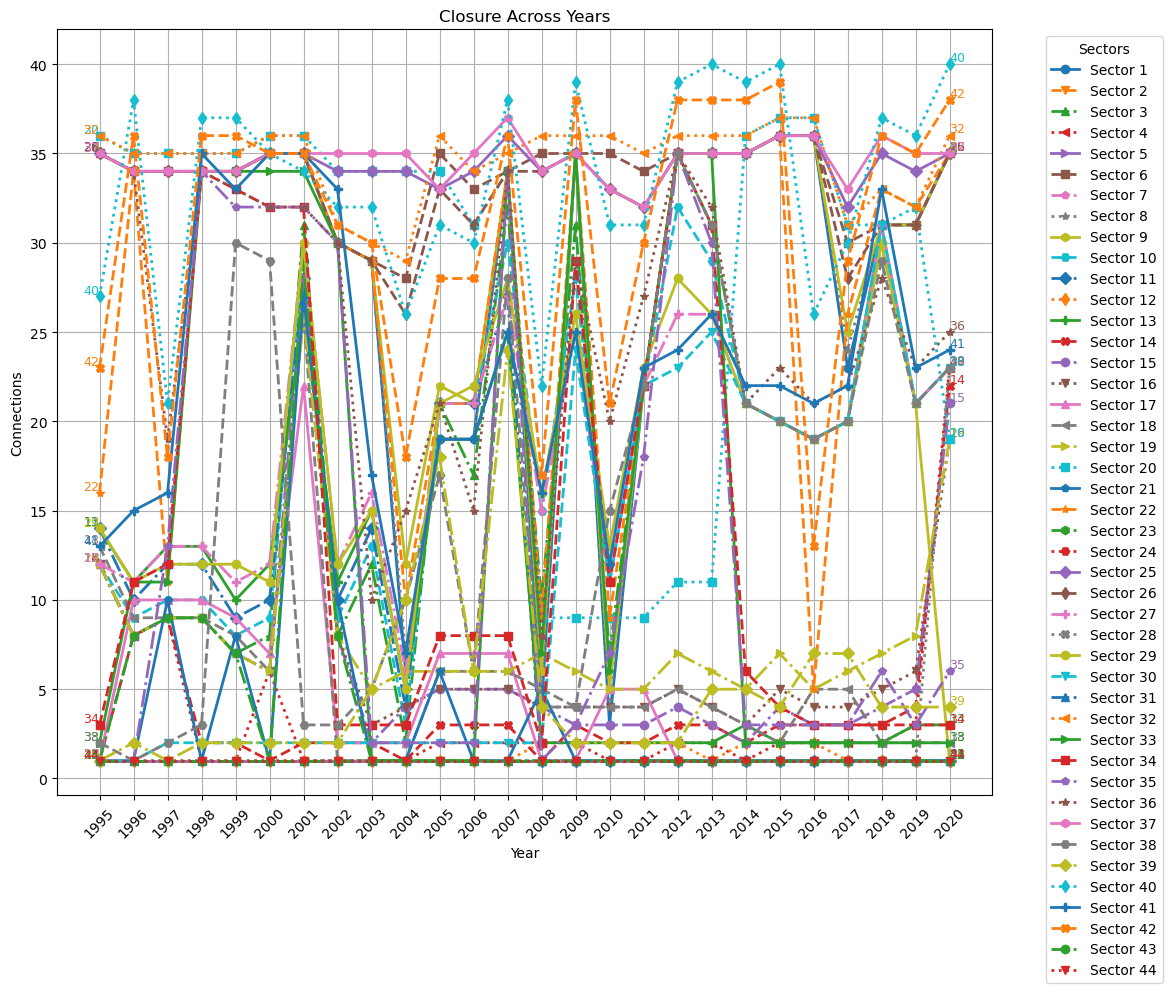

In [21]:
plot_data(closure, 'Closure Across Years')